In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
import json
from census import Census
import gmaps

# Census & gmaps API Keys
from config import (api_key, gkey)
c = Census(api_key, year=2018)

# Configure gmaps
gmaps.configure(api_key=gkey)

In [2]:
#import Racial Data CSV
csv_path = "Resources/Race Data Entry - CRDT.csv"
race_df = pd.read_csv(csv_path)

In [3]:
#Remove unneccessary columns and rows from race_df
del race_df['Deaths_Ethnicity_Unknown']
del race_df['Deaths_Ethnicity_NonHispanic']
del race_df['Deaths_Ethnicity_Hispanic']
del race_df['Cases_Ethnicity_Unknown']
del race_df['Cases_Ethnicity_NonHispanic']
del race_df['Cases_Ethnicity_Hispanic']
race_df = race_df.dropna(thresh=9)
race_df = race_df.dropna(subset={'Cases_Total'})
race_df = race_df[(race_df['Date'] == 20200715)]

In [4]:
#import state abbreviations dictionary
us_state_abbrev = {
    'AL': 'Alabama','AK': 'Alaska','AZ': 'Arizona','AR': 'Arkansas','CA': 'California',
    'CO': 'Colorado','CT': 'Connecticut','DE': 'Delaware','FL': 'Florida','GA': 'Georgia',
    'HI': 'Hawaii','ID': 'Idaho','IL': 'Illinois','IN': 'Indiana','IA': 'Iowa','KS': 'Kansas',
    'KY': 'Kentucky','LA': 'Louisiana','ME': 'Maine','MD': 'Maryland','MA': 'Massachusetts',
    'MI': 'Michigan','MN': 'Minnesota','MS': 'Mississippi','MO': 'Missouri','MT': 'Montana',
    'NE': 'Nebraska','NV': 'Nevada','NH': 'New Hampshire','NJ': 'New Jersey','NM': 'New Mexico',
    'NY': 'New York','NC': 'North Carolina','ND': 'North Dakota','OH': 'Ohio','OK': 'Oklahoma',
    'OR': 'Oregon','PA': 'Pennsylvania','RI': 'Rhode Island','SC': 'South Carolina',
    'SD': 'South Dakota','TN': 'Tennessee','TX': 'Texas','UT': 'Utah','VT': 'Vermont',
    'VA': 'Virginia','WA': 'Washington','WV': 'West Virginia','WI': 'Wisconsin','WY': 'Wyoming',
}

In [5]:
#Update the State to the full name in race_df
race_df['State']= race_df['State'].map(us_state_abbrev)

In [6]:
# Run Census Search to retrieve data on all states
census_data = c.acs5.get(("NAME", "B19013_001E", "B01003_001E", 
                          "B19301_001E",
                          "B23025_005E"), {'for': 'state:*'})

# Convert to DataFrame
census_pd = pd.DataFrame(census_data)

# Column Reordering
census_pd = census_pd.rename(columns={"B01003_001E": "Population",
                                      "B19013_001E": "Household Income",
                                      "B19301_001E": "Per Capita Income",
                                      "NAME": "State", "state": "State1"})

# Final DataFrame
census_pd = census_pd[["State", "Population", "Household Income",
                       "Per Capita Income"]]

In [7]:
#Merge race and census data frames
data_df = pd.merge(race_df, census_pd, on="State")

In [8]:
#Convert object columns to numeric
data_df['Cases_Total']=data_df['Cases_Total'].apply(pd.to_numeric)
data_df['Cases_White']=data_df['Cases_White'].apply(pd.to_numeric)

In [10]:
#import state diversity information
csv_path = "Resources/csvDataDiversity.csv"
div_df = pd.read_csv(csv_path)

#Merge the diversity dataframe with the full data dataframe
diversity_df = pd.merge(div_df, data_df, on="State")
diversity_df = diversity_df[['Date', 'State', 'Population', 'Household Income', 'Per Capita Income',
                             'WhitePerc', 'BlackPerc', 'NativePerc', 'AsianPerc', 'IslanderPerc',
                             'OtherRacePerc', 'TwoOrMoreRacesPerc','Cases_Total', 'Cases_White',
                             'Cases_Black', 'Cases_LatinX', 'Cases_Asian', 'Cases_AIAN', 
                             'Cases_NHPI', 'Cases_Multiracial', 'Cases_Other', 'Cases_Unknown',
                             'Deaths_Total','Deaths_White', 'Deaths_Black', 'Deaths_LatinX', 
                             'Deaths_Asian', 'Deaths_AIAN', 'Deaths_NHPI', 'Deaths_Multiracial',
                             'Deaths_Other', 'Deaths_Unknown']]

#Write the dataframe to a csv file
diversity_df.to_csv("projectone1_data.csv")

#View dataframe in jupyter notebook
diversity_df.head()

,Date,State,Population,Household Income,Per Capita Income,WhitePerc,BlackPerc,NativePerc,AsianPerc,IslanderPerc,...,Deaths_Total,Deaths_White,Deaths_Black,Deaths_LatinX,Deaths_Asian,Deaths_AIAN,Deaths_NHPI,Deaths_Multiracial,Deaths_Other,Deaths_Unknown
0,20200715,Alabama,4864680.0,48486.0,26846.0,0.6819,0.2658,0.0053,0.0133,0.0004,...,1211.0,593.0,516.0,NaN,4.0,NaN,NaN,NaN,23.0,75.0
1,20200715,Alaska,738516.0,76715.0,35874.0,0.6484,0.0327,0.1444,0.0630,0.0120,...,17.0,11.0,0.0,NaN,2.0,3.0,1.0,0.0,0.0,0.0
2,20200715,Arizona,6946685.0,56213.0,29265.0,0.7722,0.0439,0.0446,0.0329,0.0020,...,2434.0,970.0,69.0,601.0,27.0,353.0,NaN,NaN,48.0,366.0
3,20200715,Arkansas,2990671.0,45726.0,25635.0,0.7700,0.1541,0.0067,0.0147,0.0027,...,335.0,188.0,87.0,NaN,6.0,0.0,29.0,NaN,23.0,2.0
4,20200715,California,39148760.0,71228.0,35021.0,0.6010,0.0579,0.0076,0.1432,0.0039,...,7227.0,2190.0,621.0,3091.0,949.0,25.0,34.0,41.0,87.0,189.0


In [34]:
#pull top-five percentage white
diversity_df.sort_values(by=['WhitePerc'], inplace=True, ascending=False)
top_five_df = diversity_df.head()

#pull bottom five percentage white
diversity_df.sort_values(by=['WhitePerc'], inplace=True)
bottom_five_df = diversity_df.head()
top_five_df
bottom_five_df

,Date,State,Population,Household Income,Per Capita Income,WhitePerc,BlackPerc,NativePerc,AsianPerc,IslanderPerc,...,Deaths_Total,Deaths_White,Deaths_Black,Deaths_LatinX,Deaths_Asian,Deaths_AIAN,Deaths_NHPI,Deaths_Multiracial,Deaths_Other,Deaths_Unknown
10,20200715,Hawaii,1422029.0,78084.0,34035.0,0.2501,0.0185,0.0021,0.3775,0.1008,...,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.0
19,20200715,Maryland,6003435.0,81868.0,40517.0,0.5619,0.2978,0.0026,0.0623,0.0005,...,3341.0,1431.0,1354.0,376.0,130.0,NaN,NaN,NaN,36.0,14.0
23,20200715,Mississippi,2988762.0,43567.0,23434.0,0.5859,0.3767,0.0046,0.0095,0.0002,...,1290.0,534.0,641.0,22.0,0.0,74.0,NaN,NaN,11.0,8.0
9,20200715,Georgia,10297484.0,55679.0,29523.0,0.5904,0.3146,0.0033,0.0391,0.0006,...,3091.0,1401.0,1436.0,171.0,49.0,4.0,6.0,NaN,12.0,12.0
4,20200715,California,39148760.0,71228.0,35021.0,0.6010,0.0579,0.0076,0.1432,0.0039,...,7227.0,2190.0,621.0,3091.0,949.0,25.0,34.0,41.0,87.0,189.0


In [29]:
#For Fun
#import the Covid death counts by gender and state
csv_path = "Resources/Provisional_COVID-19_Death_Counts_by_Sex__Age__and_State (1).csv"
col_list = ['State','Sex','COVID-19 Deaths']
sex_df = pd.read_csv(csv_path, usecols=col_list)
gender_df = pd.merge(sex_df, diversity_df, on="State")

<Figure size 2880x5400 with 0 Axes>

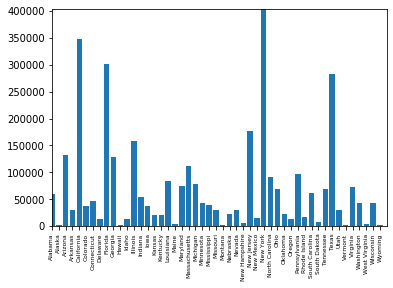

<Figure size 2880x5400 with 0 Axes>

In [27]:
#race_scatter = diversity_df.loc[:,['Cases_White', 'Cases_Black', 'Cases_LatinX', 'Cases_Asian', 
                                #'Cases_AIAN', 'Cases_NHPI', 'Cases_Multiracial', 'Cases_Other', 
                                   #'Cases_Unknown'
#]]
#race_scatter_df = pd.DataFrame(race_scatter.groupby(['State']))
x_axis =diversity_df['State']
y_axis = diversity_df['Cases_Total']
plt.bar(x_axis, y_axis)
plt.xticks(rotation = 'vertical', fontsize=6)
plt.xlim(0,len(x_axis))
plt.ylim(0, max(y_axis))
plt.figure(figsize=(40,75))